In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier,StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
df = pd.read_csv('Soil_Data_With_Ideal_Crop.csv')

print(df.head())
print(df.info())
print(df.isnull().sum()) 

   Carbon   pH    EC  Nitrogen  Phosphorus  Potassium Crop_Name  mean_smi  \
0    0.30  7.4  41.0    141.12       16.45     295.72  Soyabean  0.661869   
1    0.45  7.5  33.0    203.84       22.81     675.94  Soyabean  0.662363   
2    0.30  7.2  40.0    125.44       19.08     390.78  Soyabean  0.541200   
3    0.42  8.2  74.0    344.96       22.81     475.27  Soyabean  0.488084   
4    0.14  6.9  69.0    172.48       16.23     591.45  Soyabean  0.595245   

   mean_ndwi  mean_msi       SFI Fertility_Level Ideal_Crop  
0  -0.239644  1.009822  1.666667             Low     Tomato  
1  -0.238587  1.013599  2.000000          Medium      Onion  
2  -0.221882  1.044993  1.833333          Medium     Cotton  
3  -0.201002  1.067660  2.333333            High      Wheat  
4  -0.232174  1.050543  1.833333          Medium      Onion  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------   

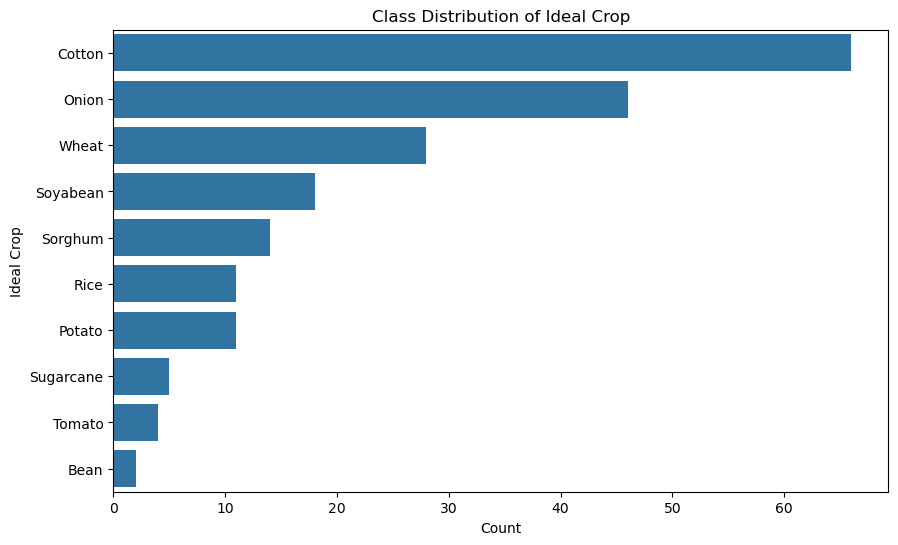

Ideal_Crop
Cotton       66
Onion        46
Wheat        28
Soyabean     18
Sorghum      14
Rice         11
Potato       11
Sugarcane     5
Tomato        4
Bean          2
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=df, y='Ideal_Crop', order=df['Ideal_Crop'].value_counts().index)
plt.title('Class Distribution of Ideal Crop')
plt.xlabel('Count')
plt.ylabel('Ideal Crop')
plt.show()

print(df['Ideal_Crop'].value_counts())

In [6]:
selected_crops = ['Cotton', 'Onion', 'Wheat', 'Soyabean', 'Sorghum', 'Rice', 'Potato']

In [7]:
df_filtered = df[df['Ideal_Crop'].isin(selected_crops)].reset_index(drop=True)

In [8]:
df_filtered.shape

(194, 13)

In [9]:
print("Updated class distribution in Ideal_Crop:\n")
print(df_filtered['Ideal_Crop'].value_counts())

Updated class distribution in Ideal_Crop:

Ideal_Crop
Cotton      66
Onion       46
Wheat       28
Soyabean    18
Sorghum     14
Rice        11
Potato      11
Name: count, dtype: int64


In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode Fertility_Level
df_filtered['Fertility_Level_Enc'] = df_filtered['Fertility_Level'].map({'Low': 0, 'Medium': 1, 'High': 2})

# Encode target variable
crop_encoder = LabelEncoder()
df_filtered['Ideal_Crop_Enc'] = crop_encoder.fit_transform(df_filtered['Ideal_Crop'])

In [11]:
X = df_filtered[['Carbon', 'pH', 'EC', 'Nitrogen', 'Phosphorus', 'Potassium',
'mean_smi', 'mean_ndwi', 'mean_msi', 'SFI', 'Fertility_Level_Enc']]

y = df_filtered['Ideal_Crop_Enc']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

## Random Forest

In [15]:
base_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
base_rf.fit(X_train_resampled, y_train_resampled)
y_pred_base = base_rf.predict(X_test)

In [16]:
print("Baseline Random Forest Model Results:\n")
print("Accuracy :", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base, average='weighted', zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_base, average='weighted', zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred_base, average='weighted', zero_division=0))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_base, target_names=crop_encoder.classes_, zero_division=0))

Baseline Random Forest Model Results:

Accuracy : 0.8717948717948718
Precision: 0.8477855477855477
Recall   : 0.8717948717948718
F1 Score : 0.8473951973951972

Classification Report:

              precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      0.50      0.67         2
        Rice       0.00      0.00      0.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       0.80      1.00      0.89         4
       Wheat       0.75      1.00      0.86         6

    accuracy                           0.87        39
   macro avg       0.77      0.76      0.75        39
weighted avg       0.85      0.87      0.85        39



In [19]:
cv_rf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_weighted', 'f1_macro']

cv_results = cross_validate(base_rf, X_train_resampled, y_train_resampled, cv=cv_rf, scoring=scoring)

print("Cross-Validation on Base Model:")
print("Mean Accuracy :", cv_results['test_accuracy'].mean())
print("Weighted F1   :", cv_results['test_f1_weighted'].mean())
print("Macro F1      :", cv_results['test_f1_macro'].mean())

Cross-Validation on Base Model:
Mean Accuracy : 0.9946306306306306
Weighted F1   : 0.9946127402328775
Macro F1      : 0.9946512243341272


In [32]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=param_grid_rf,
    cv=cv_rf,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train_resampled, y_train_resampled)

print("Best Hyperparameters from Grid Search:")
print(grid_search_rf.best_params_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters from Grid Search:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [33]:
best_rf = grid_search_rf.best_estimator_
y_pred_final = best_rf.predict(X_test)

print("\nFinal Model Evaluation with Tuned Hyperparameters:")
print("Accuracy :", accuracy_score(y_test, y_pred_final))
print("Precision:", precision_score(y_test, y_pred_final, average='weighted', zero_division=0))
print("Recall   :", recall_score(y_test, y_pred_final, average='weighted', zero_division=0))
print("F1 Score :", f1_score(y_test, y_pred_final, average='weighted', zero_division=0))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_final, target_names=crop_encoder.classes_, zero_division=0))


Final Model Evaluation with Tuned Hyperparameters:
Accuracy : 0.8717948717948718
Precision: 0.8477855477855477
Recall   : 0.8717948717948718
F1 Score : 0.8473951973951972

Classification Report:

              precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      0.50      0.67         2
        Rice       0.00      0.00      0.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       0.80      1.00      0.89         4
       Wheat       0.75      1.00      0.86         6

    accuracy                           0.87        39
   macro avg       0.77      0.76      0.75        39
weighted avg       0.85      0.87      0.85        39



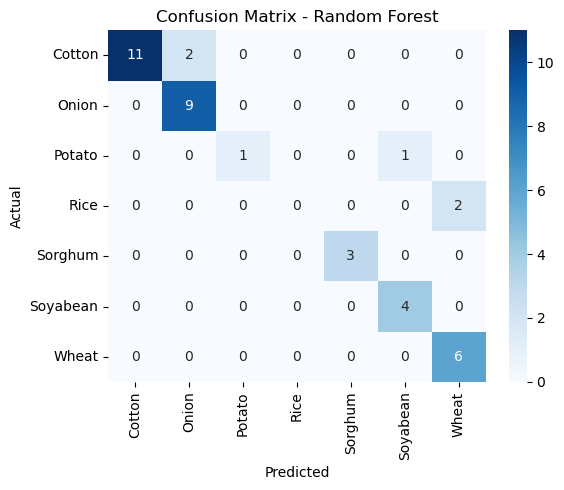

In [34]:
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=crop_encoder.classes_,
            yticklabels=crop_encoder.classes_)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

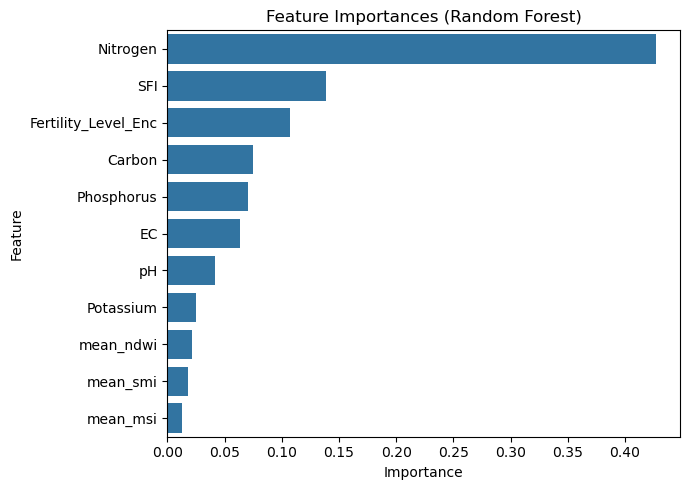

In [40]:
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns
plt.figure(figsize=(7, 5))
sns.barplot(x=importances[indices], y=feature_names[indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Gradient Boosting

In [59]:
gb_baseline = GradientBoostingClassifier(random_state=42)
gb_baseline.fit(X_train_resampled, y_train_resampled)

y_pred_gb_baseline = gb_baseline.predict(X_test)

In [61]:
print("Baseline Gradient Boosting Model Results:\n")
print("Accuracy:", accuracy_score(y_test, y_pred_gb_baseline))
print("Precision:", precision_score(y_test, y_pred_gb_baseline, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_gb_baseline, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_gb_baseline, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb_baseline, target_names=crop_encoder.classes_, zero_division=0))

Baseline Gradient Boosting Model Results:

Accuracy: 0.9487179487179487
Precision: 0.9487179487179487
Recall: 0.9487179487179487
F1 Score: 0.9487179487179487

Classification Report:
               precision    recall  f1-score   support

      Cotton       0.92      0.92      0.92        13
       Onion       0.89      0.89      0.89         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.97      0.97        39
weighted avg       0.95      0.95      0.95        39



In [63]:
print("\nCross-Validation of Baseline Model")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_weighted', 'f1_macro']
cv_results_gb = cross_validate(gb_baseline, X_train_resampled, y_train_resampled, cv=cv, scoring=scoring)
print("Mean Accuracy:", cv_results_gb['test_accuracy'].mean())
print("Weighted F1  :", cv_results_gb['test_f1_weighted'].mean())
print("Macro F1     :", cv_results_gb['test_f1_macro'].mean())


Cross-Validation of Baseline Model
Mean Accuracy: 0.9866306306306306
Weighted F1  : 0.9865945128462291
Macro F1     : 0.9864684296851672


In [67]:
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
gb_tuned = GradientBoostingClassifier(random_state=42)
grid_search_gb = GridSearchCV(gb_tuned, param_grid_gb, cv=cv, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

best_gb_model = grid_search_gb.best_estimator_
print("\nBest Hyperparameters:", grid_search_gb.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}


In [69]:
y_pred_gb_tuned = best_gb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_gb_tuned)
precision = precision_score(y_test, y_pred_gb_tuned, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred_gb_tuned, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred_gb_tuned, average='weighted', zero_division=0)
print("\nTuned Gradient Boosting Model Results:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb_tuned, target_names=crop_encoder.classes_, zero_division=0))


Tuned Gradient Boosting Model Results:
Accuracy : 0.9487
Precision: 0.9580
Recall   : 0.9487
F1 Score : 0.9491

Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.96      0.95      0.95        39



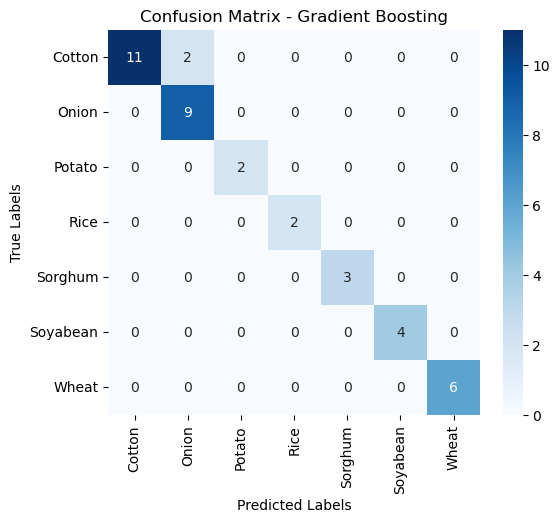

In [145]:
# Confusion Matrix
cm_gb_tuned = confusion_matrix(y_test, y_pred_gb_tuned)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_gb_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=crop_encoder.classes_, yticklabels=crop_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

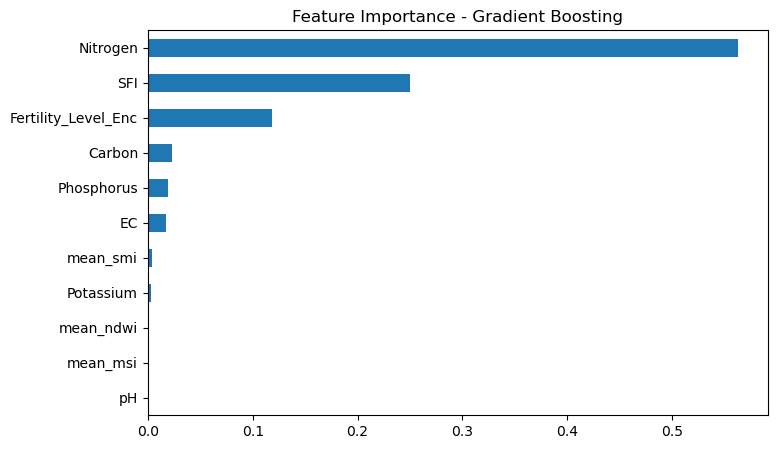

In [73]:
# Feature Importance
feature_importances = pd.Series(best_gb_model.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 5))
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance - Gradient Boosting")
plt.show()

## RFXG Model

In [82]:
rf_model = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=2, class_weight='balanced', random_state=42)
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss', random_state=42)
rfxg_model = VotingClassifier(estimators=[('rf', rf_model), ('xgb', xgb_model)], voting='soft')
rfxg_model.fit(X_train_resampled, y_train_resampled)
y_pred_rfxg = rfxg_model.predict(X_test)

In [84]:
print("Baseline RFXG Ensemble Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rfxg))
print("Precision:", precision_score(y_test, y_pred_rfxg, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_rfxg, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_rfxg, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rfxg, target_names=crop_encoder.classes_, zero_division=0))

Baseline RFXG Ensemble Model Results:
Accuracy: 0.9487179487179487
Precision: 0.9580419580419579
Recall: 0.9487179487179487
F1 Score: 0.9491452991452991

Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.96      0.95      0.95        39



In [88]:
# Cross-Validation
cv_rf_xgb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_weighted', 'f1_macro']
cv_results_rfxg = cross_validate(rfxg_model, X_train_resampled, y_train_resampled, cv=cv_rf_xgb, scoring=scoring, n_jobs=-1)

print("\n=== Cross-Validation Results (RFXG) ===")
print("Mean Accuracy :", cv_results_rfxg['test_accuracy'].mean())
print("Weighted F1   :", cv_results_rfxg['test_f1_weighted'].mean())
print("Macro F1      :", cv_results_rfxg['test_f1_macro'].mean())


=== Cross-Validation Results (RFXG) ===
Mean Accuracy : 0.9973333333333333
Weighted F1   : 0.997327812284334
Macro F1      : 0.9973972197574682


In [92]:
# Hyperparameter Tuning
param_grid = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5],
    
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [4, 6],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__subsample': [0.8],
    'xgb__colsample_bytree': [0.8]
}
grid_search_rf_xgb = GridSearchCV(rfxg_model, param_grid_rf_xgb, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_rf_xgb.fit(X_train_resampled, y_train_resampled)

best_rfxg = grid_search_rf_xgb.best_estimator_
print("\nBest Hyperparameters:", grid_search_rf_xgb.best_params_)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits

Best Hyperparameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 100, 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 4, 'xgb__n_estimators': 100, 'xgb__subsample': 0.8}


In [94]:
y_pred_best_rfxg = best_rfxg.predict(X_test)

print("\nTuned RFXG Ensemble Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_rfxg))
print("Precision:", precision_score(y_test, y_pred_best_rfxg, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_best_rfxg, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_best_rfxg, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rfxg, target_names=crop_encoder.classes_, zero_division=0))


Tuned RFXG Ensemble Model Results:
Accuracy: 0.9487179487179487
Precision: 0.9580419580419579
Recall: 0.9487179487179487
F1 Score: 0.9491452991452991

Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.96      0.95      0.95        39



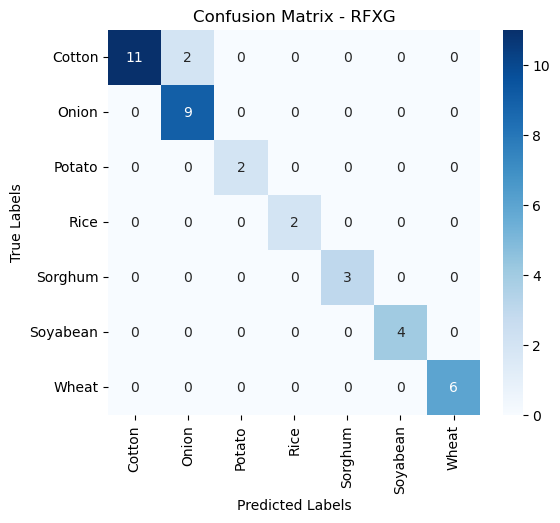

In [96]:
# Confusion Matrix
cm_rfxg = confusion_matrix(y_test, y_pred_best_rfxg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rfxg, annot=True, fmt='d', cmap='Blues', xticklabels=crop_encoder.classes_, yticklabels=crop_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - RFXG')
plt.show()

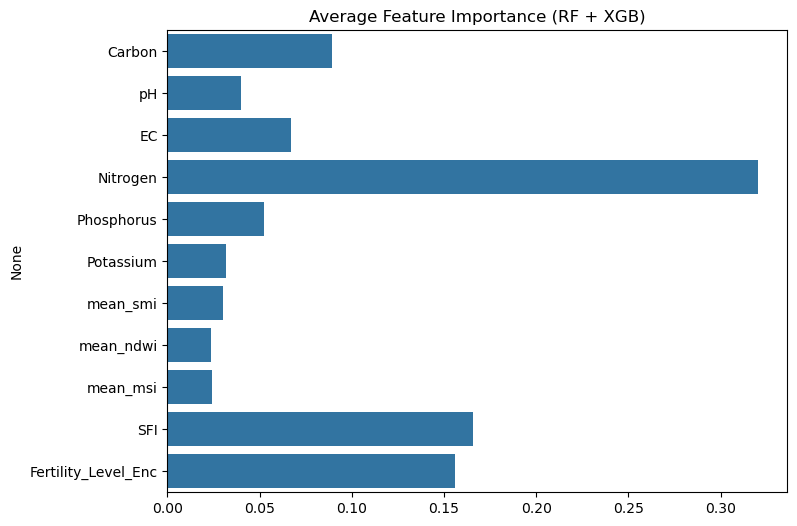

In [98]:
# Feature Importance
rf_feature_importance = best_rfxg.named_estimators_['rf'].feature_importances_
xgb_feature_importance = best_rfxg.named_estimators_['xgb'].feature_importances_
avg_feature_importance = (rf_feature_importance + xgb_feature_importance) / 2

plt.figure(figsize=(8, 6))
sns.barplot(x=avg_feature_importance, y=feature_names)
plt.title('Average Feature Importance (RF + XGB)')
plt.show()

## Stacking Ensemble 

In [42]:
# Baseline Stacking Ensemble Model
baseline_stack = StackingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(random_state=42)),
        ('xgb', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
)
baseline_stack.fit(X_train_resampled, y_train_resampled)
y_pred_baseline = baseline_stack.predict(X_test)

In [43]:
print("Baseline Stacking Ensemble:")
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_baseline, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_baseline, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_baseline, target_names=crop_encoder.classes_, zero_division=0))

Baseline Stacking Ensemble:
Accuracy: 0.9487179487179487
Precision: 0.9580419580419579
Recall: 0.9487179487179487
F1 Score: 0.9491452991452991

Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.96      0.95      0.95        39



In [46]:
# Cross-Validation
cv_stack = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_stack = cross_validate(
    baseline_stack, X_train_resampled, y_train_resampled,
    cv=cv_stack,
    scoring=['accuracy', 'f1_weighted', 'f1_macro'],
    n_jobs=-1
)

print("\n=== Cross-Validation Results (Stacking) ===")
print("Mean Accuracy:", cv_scores_stack['test_accuracy'].mean())
print("Weighted F1:", cv_scores_stack['test_f1_weighted'].mean())
print("Macro F1:", cv_scores_stack['test_f1_macro'].mean())


=== Cross-Validation Results (Stacking) ===
Mean Accuracy: 0.9973333333333333
Weighted F1: 0.997327812284334
Macro F1: 0.9973972197574682


In [48]:
# Hyperparameter Tuning with expanded parameter space
param_grid_stack = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [None, 10],
    'xgb__n_estimators': [100, 150],
    'xgb__max_depth': [3, 6],
    'xgb__learning_rate': [0.05, 0.1],
    'svm__C': [1, 10],
    'svm__kernel': ['rbf', 'linear']
}
grid_stack = GridSearchCV(StackingClassifier(
    estimators=[('rf', RandomForestClassifier(random_state=42)), ('xgb', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)), ('svm', SVC(probability=True, random_state=42))],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1
), param_grid_stack, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_stack.fit(X_train_resampled, y_train_resampled)

best_stack = grid_stack.best_estimator_
print("\nBest Hyperparameters:", grid_stack.best_params_)

Fitting 3 folds for each of 128 candidates, totalling 384 fits

Best Hyperparameters: {'rf__max_depth': None, 'rf__n_estimators': 100, 'svm__C': 1, 'svm__kernel': 'rbf', 'xgb__learning_rate': 0.05, 'xgb__max_depth': 3, 'xgb__n_estimators': 100}


In [49]:
# Prediction and Evaluation
y_pred_best_stack = best_stack.predict(X_test)
print("\nTuned Stacking Ensemble Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_stack))
print("Precision:", precision_score(y_test, y_pred_best_stack, average='weighted', zero_division=0))
print("Recall:", recall_score(y_test, y_pred_best_stack, average='weighted', zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_best_stack, average='weighted', zero_division=0))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_stack, target_names=crop_encoder.classes_, zero_division=0))


Tuned Stacking Ensemble Results:
Accuracy: 0.9487179487179487
Precision: 0.9580419580419579
Recall: 0.9487179487179487
F1 Score: 0.9491452991452991

Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.85      0.92        13
       Onion       0.82      1.00      0.90         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.95        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.96      0.95      0.95        39



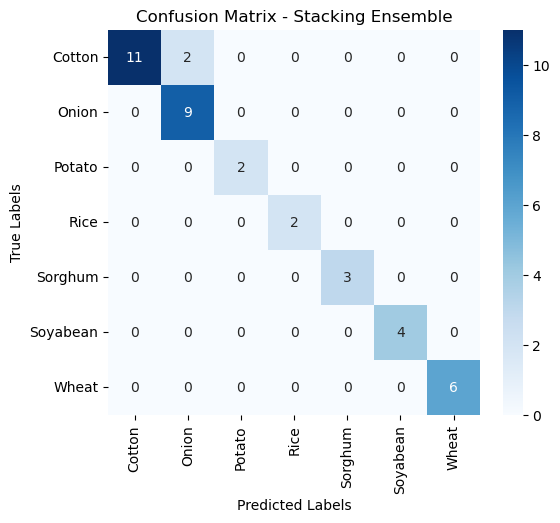

In [50]:

# Confusion Matrix
cm_stack = confusion_matrix(y_test, y_pred_best_stack)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stack, annot=True, fmt='d', cmap='Blues', xticklabels=crop_encoder.classes_, yticklabels=crop_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Stacking Ensemble')
plt.show()


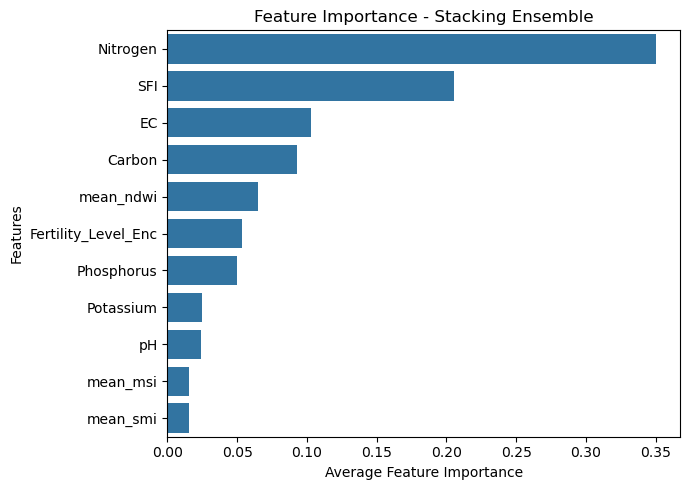

In [61]:
# Feature Importance
# rf_feature_importance_stack = best_stack.named_estimators_['rf'].feature_importances_
# xgb_feature_importance_stack = best_stack.named_estimators_['xgb'].feature_importances_
# avg_feature_importance_stack = (rf_feature_importance_stack + xgb_feature_importance_stack) / 2

# plt.figure(figsize=(8, 6))
# sns.barplot(x=avg_feature_importance_stack, y=feature_names)
# plt.title('Feature Importance Stacking Ensemble')
# plt.show()
avg_feature_importance_stack = (rf_feature_importance_stack + xgb_feature_importance_stack) / 2

# Sort the importances and feature names
sorted_indices = np.argsort(avg_feature_importance_stack)[::-1]  # Descending order
sorted_importance = avg_feature_importance_stack[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(x=sorted_importance, y=sorted_feature_names)
plt.title('Feature Importance - Stacking Ensemble')
plt.xlabel('Average Feature Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
# feature_importances = pd.Series(best_stack.feature_importances_, index=X.columns)
# plt.figure(figsize=(7, 5))
# feature_importances.sort_values().plot(kind='barh')
# plt.title("Feature Importance - Stacking Ensemble")
# plt.show()

## LightGBM

In [125]:
from lightgbm import LGBMClassifier

base_lgbm = LGBMClassifier(class_weight='balanced', random_state=42)
base_lgbm.fit(X_train_resampled, y_train_resampled)
y_pred_base_lgbm = base_lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 11
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [127]:
# Base model evaluation
print("Baseline LightGBM Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_base_lgbm))
print("Precision:", precision_score(y_test, y_pred_base_lgbm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_base_lgbm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_base_lgbm, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_base_lgbm, target_names=crop_encoder.classes_))

Baseline LightGBM Model Results:
Accuracy: 0.9743589743589743
Precision: 0.976923076923077
Recall: 0.9743589743589743
F1 Score: 0.9745209176788123
Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.92      0.96        13
       Onion       0.90      1.00      0.95         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.97        39
   macro avg       0.99      0.99      0.99        39
weighted avg       0.98      0.97      0.97        39



In [129]:
# Cross-validation
cv_lgbm = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy', 'f1_weighted', 'f1_macro']
cv_results = cross_validate(base_lgbm, X_train_resampled, y_train_resampled, cv=cv_lgbm, scoring=scoring)

print("\nCross-Validation Results:")
print("Mean Accuracy:", cv_results['test_accuracy'].mean())
print("Weighted F1:", cv_results['test_f1_weighted'].mean())
print("Macro F1:", cv_results['test_f1_macro'].mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 642
[LightGBM] [Info] Number of data points in the train set: 296, number of used features: 11
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [131]:
param_grid_lgbm = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_samples': [20, 50]
}
grid_search_lgbm = GridSearchCV(LGBMClassifier(random_state=42), param_grid=param_grid_lgbm, cv=cv_lgbm, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_search_lgbm.fit(X_train_resampled, y_train_resampled)

print("\nBest Hyperparameters from Grid Search:")
print(grid_search_lgbm.best_params_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 853
[LightGBM] [Info] Number of data points in the train set: 371, number of used features: 11
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [133]:
# Final model evaluation
best_lgbm = grid_search_lgbm.best_estimator_
y_pred_best_lgbm = best_lgbm.predict(X_test)

print("\nFinal LightGBM Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_best_lgbm))
print("Precision:", precision_score(y_test, y_pred_best_lgbm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best_lgbm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_best_lgbm, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_best_lgbm, target_names=crop_encoder.classes_))



Final LightGBM Model Results:
Accuracy: 0.9743589743589743
Precision: 0.976923076923077
Recall: 0.9743589743589743
F1 Score: 0.9745209176788123
Classification Report:
               precision    recall  f1-score   support

      Cotton       1.00      0.92      0.96        13
       Onion       0.90      1.00      0.95         9
      Potato       1.00      1.00      1.00         2
        Rice       1.00      1.00      1.00         2
     Sorghum       1.00      1.00      1.00         3
    Soyabean       1.00      1.00      1.00         4
       Wheat       1.00      1.00      1.00         6

    accuracy                           0.97        39
   macro avg       0.99      0.99      0.99        39
weighted avg       0.98      0.97      0.97        39



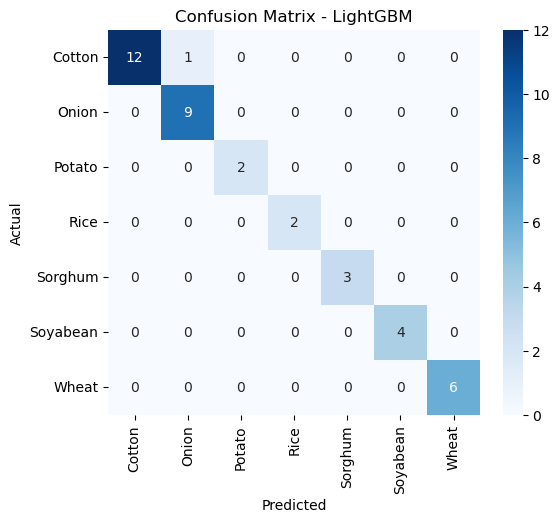

In [135]:
conf_matrix = confusion_matrix(y_test, y_pred_best_lgbm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=crop_encoder.classes_, yticklabels=crop_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LightGBM')
plt.show()

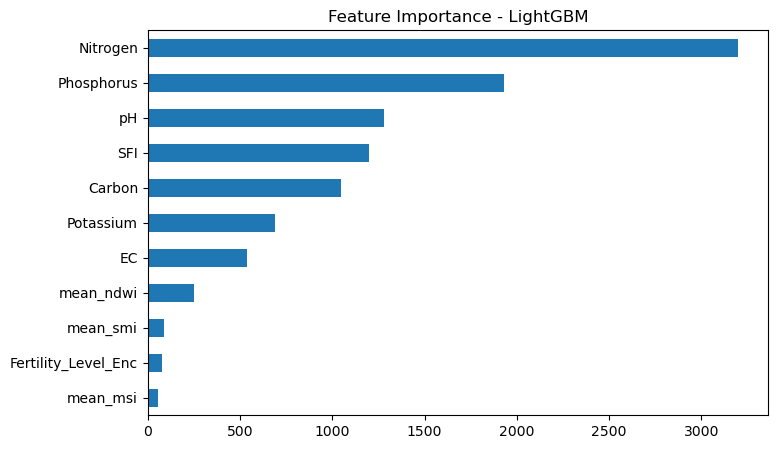

In [139]:
# Feature Importance
feature_importances = pd.Series(best_lgbm.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 5))
feature_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance - LightGBM")
plt.show()